## 1. Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import uncertainty_wizard as uwiz
import matplotlib.pyplot as plt
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout, UwizGaussianDropout, UwizGaussianNoise
from uncertainty_wizard.models._stochastic._stochastic_mode import StochasticMode
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. Load and preprocess MNIST

Lenght of training samples:  60000
Lenght of test samples:  10000
Shape:  (28, 28)
-----------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 uwiz_bernoulli_dropout (Uw  (None, 12, 12, 64)        0         
 izBernoulliDropout)                                             
                                                                 
 flatten (Flatten)           (None, 921

/opt/homebrew/lib/python3.11/site-packages/uncertainty_wizard/models/stochastic_utils/layers.py:25: UncertaintyWizardWarning: Looks like you are passing an <class 'uncertainty_wizard.models.stochastic_utils.layers.UwizBernoulliDropout'> layer.For SequentialStochastic layers, it is sufficient to pass a layer ofthe corresponding keras layer <class 'keras.src.layers.regularization.dropout.Dropout'>.We trust you that you know what you did and set up the stochastic mode correctly.Your layer will thus not be replaced, but added to the model as you provided it.
  warnings.warn(


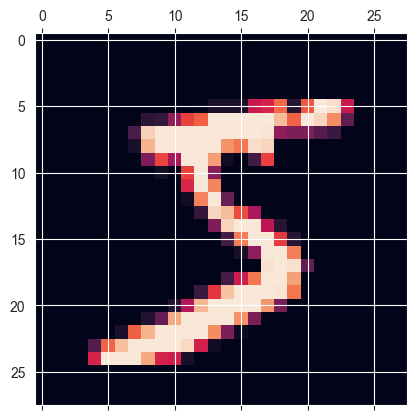

In [2]:
# Load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('Lenght of test samples: ', len(x_test))

# Shape 
print('Shape: ', x_train[0].shape)
print('-----------------------------------------------------------------')

# Preprocess the data
x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

model = uwiz.models.StochasticSequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(UwizBernoulliDropout(0.5, stochastic_mode=StochasticMode()))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

es_callback = tf.keras.callbacks.EarlyStopping(patience=2)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="./data/logs", histogram_freq=1)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.legacy.Adadelta(),
                metrics=['accuracy'])

model.summary()
plt.matshow(x_train[0])

## 3. Train

In [ ]:
history = model.fit(x_train,
                    y_train,
                    validation_split=0.1,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
                    callbacks=[es_callback, tb_callback])

# Save the model
model.inner.save_weights('mnist_model_stochastic_weights.h5')
print("Model weights saved to disk")

## Launch TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir data/logs

## 4. Plot Traning & Validation Accuracy and Loss 

In [ ]:
# Plot training & validation accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 5. Evaluate Model

In [ ]:
# Load the saved model weights
model.inner.load_weights('mnist_model_stochastic_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy', test_acc)

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

## 5. Plot Predictions & Confusion Matrix

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

## 6. Analyze the Uncertainty

In [ ]:
# Load the saved model weights 
model.inner.load_weights('mnist_model_stochastic_weights.h5')
print("Model weights loaded from disk")

# Perform uncertainty quantification
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                    quantifier=quantifiers,
                                    batch_size=64,
                                    sample_size=32,
                                    verbose=1)


## 7. Plots for Uncertainty Analysis

In [ ]:
# Plot the uncertainty distribution
uncertainty_scores = results[1][1]
plt.figure(figsize=(8, 6))
plt.hist(uncertainty_scores, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Uncertainty Scores')
plt.xlabel('Uncertainty Score')
plt.ylabel('Frequency')
plt.show()

# Plot the predictive confidence score
confidence_scores = results[1][0]
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=50, alpha=0.7, color='green')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.show()

# Plot the predictive confidence score vs uncertainty score
plt.figure(figsize=(8, 6))
plt.scatter(confidence_scores, uncertainty_scores, alpha=0.5, color='red')
plt.title('Predictive Confidence Score vs Uncertainty Score')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Uncertainty Score')
plt.show()

# Plot PCS and Mean Softmax scores for a subset of the test set data  
#qualitative, visual correlation between each image and its corresponding scores.
num_samples = 25
pcs_scores, mean_softmax_scores = results[0][1], results[1][1]
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'PCS: {pcs_scores[i]:.2f}\nMean Softmax: {mean_softmax_scores[i]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plot distribution of PCS and Mean Softmax scores
pcs_scores = results[0][1]
mean_softmax_scores = results[1][1]
plt.subplot(1, 2, 1)
plt.hist(pcs_scores, bins=50, alpha=0.7)
plt.xlabel('PCS Score')
plt.ylabel('Frequency')
plt.title('Distribution of PCS Scores')
plt.subplot(1, 2, 2)
plt.hist(mean_softmax_scores, bins=50, alpha=0.7)
plt.xlabel('Mean Softmax Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Softmax Scores')
plt.tight_layout()
plt.show()


In [ ]:
pcs_scores = results[0][1][:num_samples]  
mean_softmax_scores = results[1][1][:num_samples]

# Plot PCS scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(num_samples), pcs_scores)
plt.xlabel('Sample')
plt.ylabel('PCS Score')
plt.title('PCS Scores for Test Samples')

# Plot Mean Softmax scores
plt.subplot(1, 2, 2)
plt.bar(range(num_samples), mean_softmax_scores)
plt.xlabel('Sample')
plt.ylabel('Mean Softmax Score')
plt.title('Mean Softmax Scores for Test Samples')

plt.tight_layout()
plt.show()

In [ ]:
print(x_test.shape)
pcs_predictions = results[0][0]
pcs_confidences = results[0][1]
mean_softmax_predictions = results[1][0]
mean_softmax_confidences = results[1][1]


plt.hist(pcs_confidences, bins=50, alpha=0.7, color='blue', label='PCS')
plt.hist(mean_softmax_confidences, bins=50, alpha=0.7, color='green', label='Mean Softmax')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()



plt.hist(pcs_predictions, bins=50, alpha=0.7, color='blue', label='PCS Predictions')
plt.hist(mean_softmax_predictions, bins=50, alpha=0.7, color='green', label='Mean Softmax Predictions')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
